In [78]:
from svdunfold import SVDunfold
import svdunfold
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.signal import fftconvolve
from matplotlib.colors import LogNorm
from scipy import stats
import random
from scipy.interpolate import interp1d
from scipy.stats import poisson
from scipy.fft import fft, fftfreq

In [79]:
nevents=100000
x0 = 1842 # M2
gamma0 = 6
x1 =  2047 # M1
gamma1 = 13.2
mu = 0
sigma=14.49
gaussian_par=[mu,sigma]
cauchy_par_test_0=[x0,gamma0]
cauchy_par_test_1=[x1,gamma1]

cauchy_par_0=[x0-10,gamma0+1]
cauchy_par_1=[x1+20,gamma1-1]

x_min=1400
x_max=2500
x_nbins=220
b_min=1400
b_max=2500
b_nbins=220
nevents_test_0=nevents-40000
nevents_test_1=nevents+100000

def bins_and_centers(nbins, low, high):
    bins = np.linspace(low, high, nbins + 1)
    bin_centers = (bins + (bins[1] - bins[0]) / 2)[:-1]
    return bins, bin_centers


def add_smearing(x):
    smear = np.random.normal(gaussian_par[0],gaussian_par[1])
    return x + smear

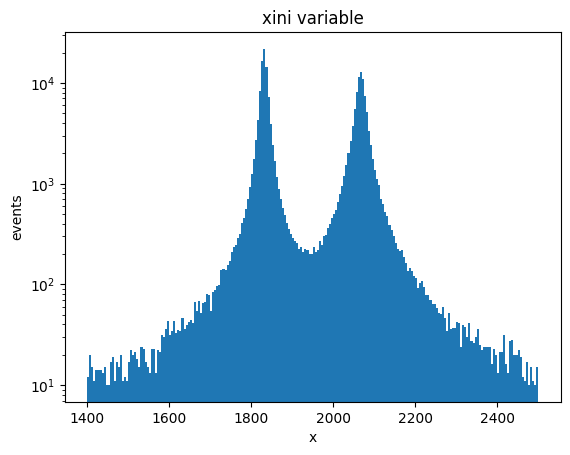

In [80]:
xini_peak_0 = stats.cauchy.rvs(cauchy_par_0[0], cauchy_par_0[1], nevents) 
xini_peak_1 = stats.cauchy.rvs(cauchy_par_1[0], cauchy_par_1[1], nevents) 


xini_peak = np.append(xini_peak_0, xini_peak_1)

plt.hist(xini_peak, x_nbins, range=[x_min,x_max])
plt.title("xini variable")
plt.ylabel("events")
plt.xlabel("x")
plt.yscale("log")

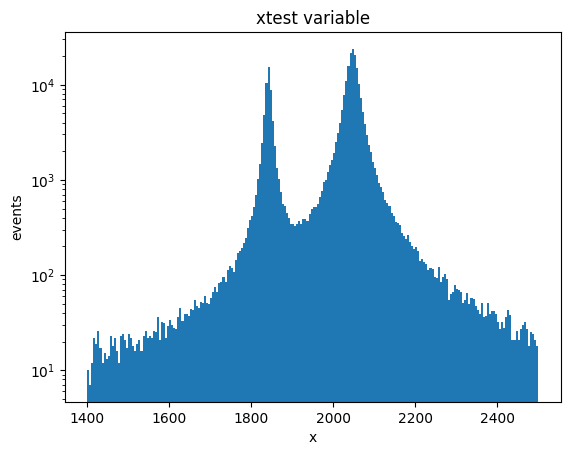

In [81]:
xini_peak_test_0 = stats.cauchy.rvs(cauchy_par_test_0[0], cauchy_par_test_0[1], nevents_test_0) 
xini_peak_test_1 = stats.cauchy.rvs(cauchy_par_test_1[0], cauchy_par_test_1[1], nevents_test_1) 

xini_peak_test = np.append(xini_peak_test_0, xini_peak_test_1)

plt.hist(xini_peak_test, x_nbins, range=[x_min,x_max])
plt.title("xtest variable")
plt.ylabel("events")
plt.xlabel("x")
plt.yscale("log")

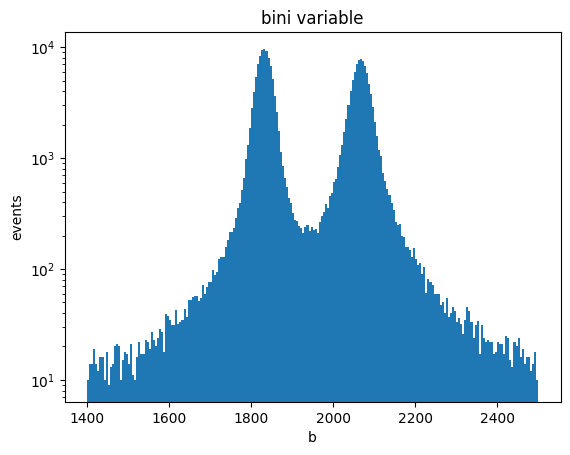

In [82]:
b_ini_gen = []

for i in xini_peak:
    b_ini_gen.append(add_smearing(i))


plt.hist(b_ini_gen, x_nbins, range=[x_min,x_max])
plt.title("bini variable")
plt.ylabel("events")
plt.xlabel("b")
plt.yscale("log")

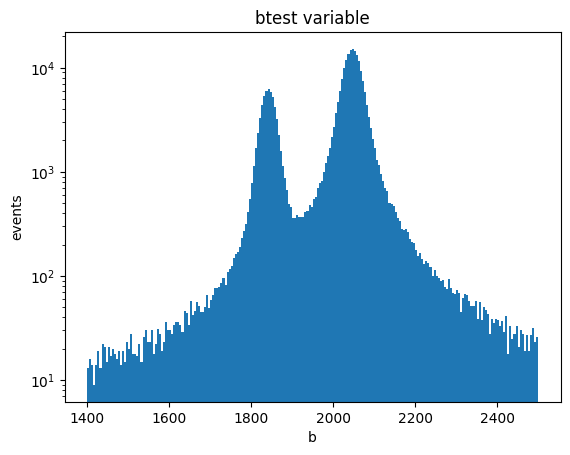

In [83]:
b_test_gen = []

for i in xini_peak_test:
    b_test_gen.append(add_smearing(i))

plt.hist(b_test_gen, x_nbins, range=[x_min,x_max])
plt.title("btest variable")
plt.ylabel("events")
plt.xlabel("b")
plt.yscale("log")

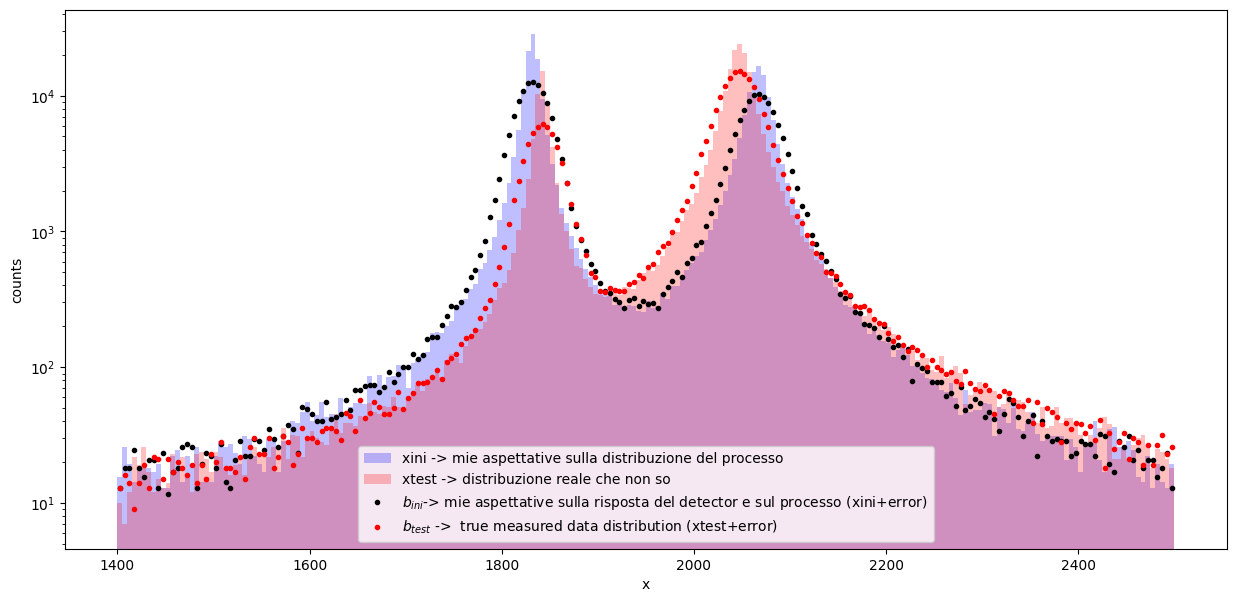

In [84]:
bins_x, bin_centers_x = bins_and_centers(x_nbins, x_min, x_max)
bins_b, bin_centers_b = bins_and_centers(b_nbins, b_min, b_max)

x_ini_gen = xini_peak
x_ini = np.histogram(x_ini_gen, bins_x)
x_test_gen = xini_peak_test
x_test = np.histogram(x_test_gen, bins_x)

scale_factor = len(x_test_gen)/len(x_ini_gen)

b_ini = np.histogram(b_ini_gen, bins_b)
b_test = np.histogram(b_test_gen, bins_b)


plt.figure(figsize=(15, 7))

plt.hist(x_ini_gen, density=False, bins=x_nbins, histtype="stepfilled", color="blue", 
         label="xini -> mie aspettative sulla distribuzione del processo", alpha=0.25, weights=scale_factor*np.ones(len(x_ini_gen)), range=[x_min, x_max])
plt.hist(x_test_gen, density=False, bins=x_nbins, histtype="stepfilled", color="red", label="xtest -> distribuzione reale che non so", alpha=0.25, range=[x_min, x_max])

binsb, bin_centers_b=bins_and_centers(b_nbins, b_min, b_max)

plt.plot(bin_centers_b, b_ini[0]*scale_factor, ".", color="black", label="$b_{ini}$-> mie aspettative sulla risposta del detector e sul processo (xini+error)")
plt.plot(bin_centers_b, b_test[0], ".", color="red", label="$b_{test}$ ->  true measured data distribution (xtest+error)")

plt.xlabel("x")
plt.ylabel("counts")
plt.yscale("log")
plt.legend()

In [184]:
mean = b_test[0] #medie delle n poissons

x_vals = np.arange(min(mean), max(mean)) #"dati" su cui calcolare la poisson
scaled_distributions = []
for lam in mean:
    poisson_probs = stats.poisson.pmf(x_vals, mu=lam) #* sum(b_test[0]) / len(b_test[0])
    scaled_distributions.append(poisson_probs)

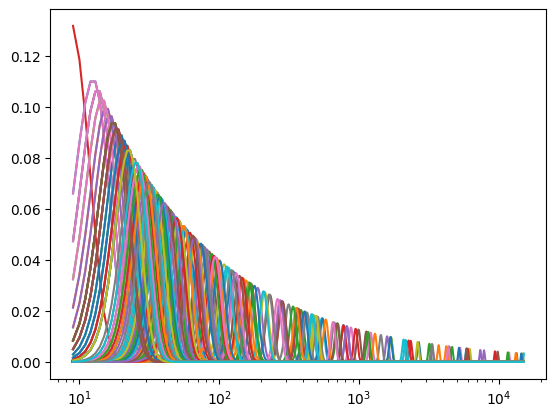

In [185]:
for lam in range(len(mean)):
    plt.plot(x_vals, scaled_distributions[lam])
    plt.xscale("log")

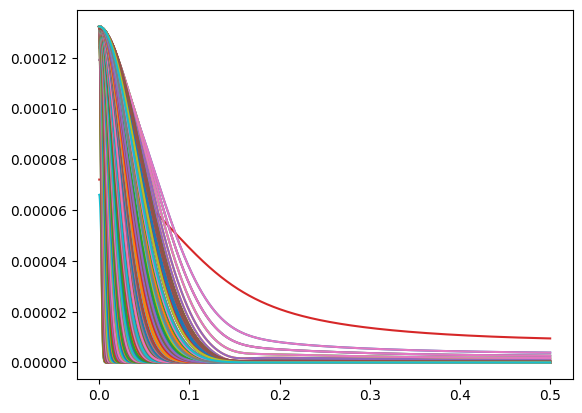

In [190]:
scaled_distributions = np.array(scaled_distributions)

scaled_distributions = np.array([np.concatenate((i, np.zeros(2**14-len(x_vals)))) for i in scaled_distributions])

# Number of sample points
N = len(x_vals)
# sample spacing
T = (max(x_vals)-min(x_vals))/N

yf = fft(scaled_distributions)
xf = fftfreq(N, T)[:N//2]

convoluted = []
for lam in range(len(mean)):
    convoluted.append(2.0/N * np.abs(yf[lam][0:N//2]))
    plt.plot(xf, convoluted[lam])

plt.show()


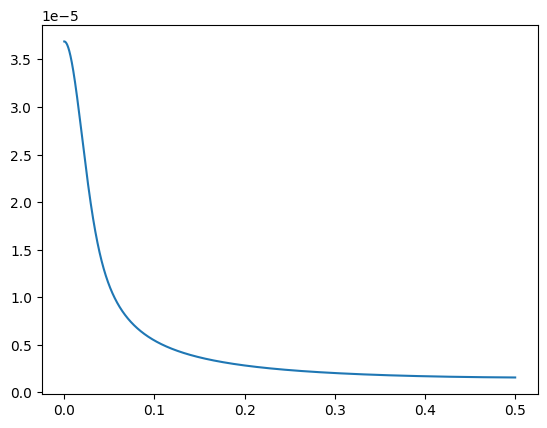

In [196]:
gaussian = stats.norm.pdf(x_vals,gaussian_par[0], gaussian_par[1])
gaussian = np.array(gaussian)

A = np.zeros(2**14-len(x_vals))
gaussian = np.concatenate((gaussian,A))

# Number of sample points
N = len(x_vals)
# sample spacing
T = (max(x_vals)-min(x_vals))/N

yf = fft(gaussian)
xf = fftfreq(N, T)[:N//2]

plt.plot(xf,2.0/N * np.abs(yf[0:N//2]))
convoluted_gaussian = 2.0/N * np.abs(yf[0:N//2])
plt.show()

ValueError: x and y must have same first dimension, but have shapes (7554,) and (1,)

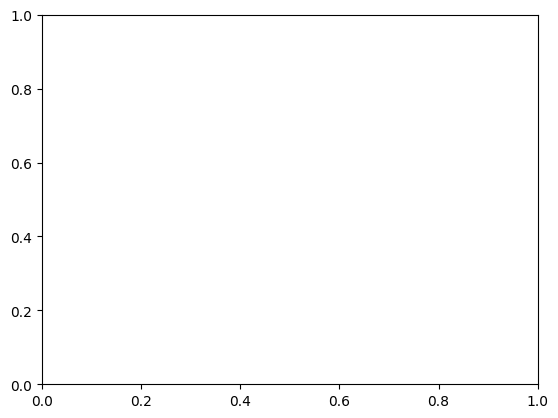

In [198]:
div = []
for j in range(len(convoluted)):
    for i in range(len(convoluted_gaussian)):
        div.append(convoluted[j][i]/convoluted_gaussian[i])

